In [39]:
import jetnet
from jetnet.datasets import JetNet
import numpy as np
import matplotlib.pyplot as plt
import gen_metrics
from tqdm import tqdm
import pandas as pd
from IPython.display import Markdown, display
import pickle
import plotting
from typing import OrderedDict
import mplhep as hep

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
import os

plot_dir = "../plots/gapt_analysis/Nov11"
_ = os.system(f"mkdir -p {plot_dir}")

data_dir = "../saved_data/"
model = 162

In [37]:
loss_keys = {"fpd": "FPD", "fpnd": "FPND", "kpd": "KPD", "w1m": r"$W^M_1$"}

losses = {key: np.loadtxt(f"{data_dir}/{model}/{key}.txt") for key in loss_keys}
losses['fpnd'] = losses['fpnd'][:, np.newaxis]

In [93]:
def correlation_plot(xkey, ykey, plot_range, scilimits=False):
    xlabel = loss_keys[xkey]
    ylabel = loss_keys[ykey]

    xlosses = losses[xkey][:, 0]
    ylosses = losses[ykey][:, 0]

    if ykey == "kpd":
        ylosses += losses[ykey][:, 1]

    plt.rcParams.update({"font.size": 16})
    plt.style.use(hep.style.CMS)

    fig = plt.figure(figsize=(12, 10))
    # h = plt.hist2d(xlosses, ylosses, bins=40, range=plot_range, cmap="jet")
    h = plt.hist2d(
        xlosses,
        ylosses,
        bins=(np.logspace(*np.log10(plot_range[0]), 40), np.logspace(*np.log10(plot_range[1]), 40)),
        range=plot_range,
        cmap="jet",
    )
    # if scilimits:

    # if plot_range[0][1] < 0.1:
    #     plt.ticklabel_format(axis="x", scilimits=(0, 0), useMathText=True)
    # if plot_range[1][1] < 0.1:
    #     plt.ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)

    c = plt.colorbar(h[3])
    c.set_label("Number of batches")
    plt.xlabel(xlabel, loc="left")
    plt.ylabel(ylabel)
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"{xlabel} vs {ylabel} Correlation")
    plt.savefig(f"{plot_dir}/{model}_{xkey}v{ykey}.pdf", bbox_inches="tight")
    plt.show()


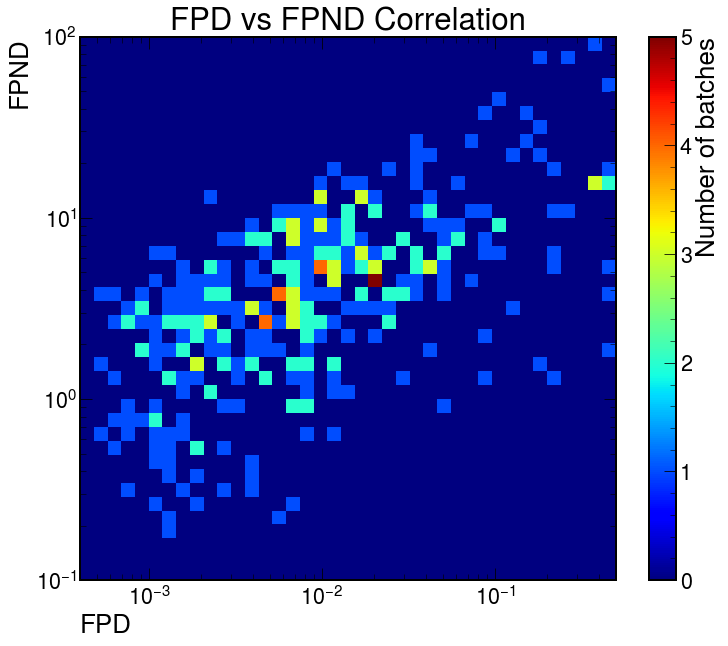

In [105]:
correlation_plot("fpd", "fpnd", [[4e-4, 0.5], [1e-1, 100]])

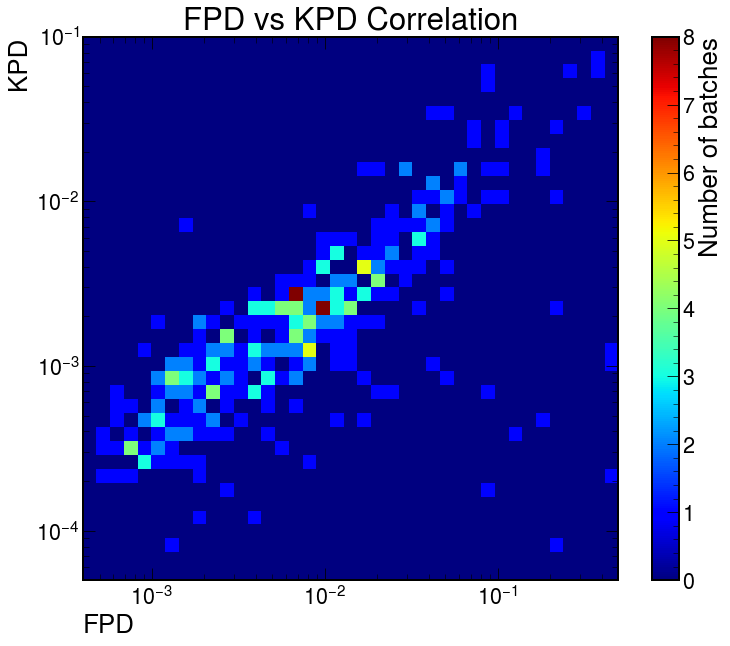

In [106]:
correlation_plot("fpd", "kpd", [[4e-4, 0.5], [5e-5, 0.1]], scilimits=True)


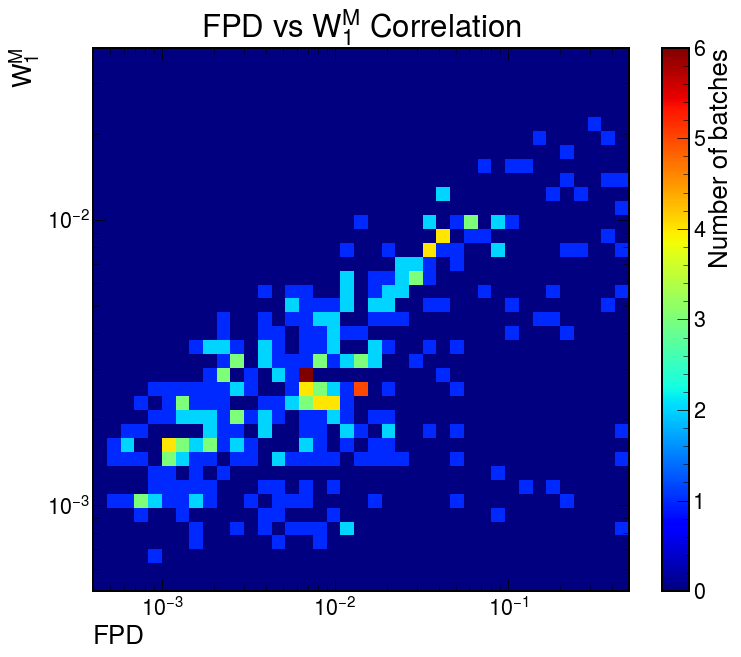

In [111]:
correlation_plot("fpd", "w1m", [[4e-4, 0.5], [5e-4, 4e-2]], scilimits=True)


In [116]:
print(np.min(losses['fpd'][:, 0]))
min_fpd = np.min(losses['fpd'][:, 0])
print(losses['fpd'][:, 1][np.argmin(losses['fpd'][:, 0])])
min_fpd_err = losses['fpd'][:, 1][np.argmin(losses['fpd'][:, 0])]
print(np.sum(losses['kpd'], axis=1)[np.argmin(losses['fpd'][:, 0])])
print(losses['w1m'][:, 0][np.argmin(losses['fpd'][:, 0])])
print(np.argmin(losses['fpd'][:, 0]) * 5)

0.00039494437002767104
1.6079706056339805e-05
0.00015920740407288214
0.0007647135795280332
1685


In [117]:
print(np.min(np.sum(losses['kpd'], axis=1)))
print(losses['kpd'][:, 1][np.argmin(losses['kpd'][:, 0])])
print(losses['fpd'][:, 0][np.argmin(losses['kpd'][:, 0])])
print(losses['w1m'][:, 0][np.argmin(losses['kpd'][:, 0])])
print(np.argmin(losses['kpd'][:, 0]) * 5)

8.88640662697693e-05
5.50301883722959e-06
0.22055455856711711
0.0010978168042935425
1125


In [119]:
print(np.min(losses['w1m'][:, 0]))
min_idx = np.argmin(losses['w1m'][:, 0])
print(min_idx * 5)
print(losses['fpd'][:, 0][min_idx])
print(losses['fpnd'][:, 0][min_idx])
print(np.sum(losses['kpd'], axis=1)[min_idx])

0.0006274817399960004
1740
0.0008508698333059454
1.9965005806967042
0.00030485624808473396


In [113]:
print(np.min(losses['fpnd'][:, 0]))
print(np.argmin(losses['fpnd'][:, 0]) * 5)
print(losses['fpd'][:, 0][np.argmin(losses['fpnd'][:, 0])])
print(losses['kpd'][:, 0][np.argmin(losses['fpnd'][:, 0])])

0.19972998007801834
865
0.0013954045144753918
0.0009938770846610696


In [30]:
print(np.sum(losses['fpd'][:, 0] < (min_fpd + 5 * min_fpd_err)))
selector = losses['fpd'][:, 0] < (min_fpd + 5 * min_fpd_err)
indices = np.where(selector)[0]
min_kpd_idx = indices[np.argmin(np.sum(losses['kpd'], axis=1)[indices])]
print(np.min(np.sum(losses['kpd'], axis=1)[indices]))
print(min_kpd_idx * 5)
min_fpnd_idx = indices[np.argmin(losses['fpnd'][indices])]
print(np.min(losses['fpnd'][indices]))
print(min_fpnd_idx * 5)
min_w1m_idx = indices[np.argmin(losses['w1m'][:, 0][indices])]
print(np.min(losses['w1m'][:, 0][indices]))
print(min_w1m_idx * 5)

23
4.944004702583093e-05
880
0.24396959886453828
2475
0.0009242178828641773
3840


In [34]:
print(np.sum(losses['w1m'][:, 0] < 0.001))
selector = losses['w1m'][:, 0] < 0.001
indices = np.where(selector)[0]
min_kpd_idx = indices[np.argmin(np.sum(losses['kpd'], axis=1)[indices])]
print(np.min(np.sum(losses['kpd'], axis=1)[indices]))
print(min_kpd_idx * 5)
min_fpnd_idx = indices[np.argmin(losses['fpnd'][indices])]
print(np.min(losses['fpnd'][indices]))
print(min_fpnd_idx * 5)
min_w1m_idx = indices[np.argmin(losses['fpd'][:, 0][indices])]
print(np.min(losses['fpd'][:, 0][indices]))
print(min_w1m_idx * 5)

23
0.00010584044186053186
3305
0.25018242602811824
3240
0.0005254394555580408
3840


/var/folders/fh/cwyrvktn5bz76x4cpy_lbgnh0000gn/T/ipykernel_33867/145633110.py:3: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 1])


(7.177439527188486e-09, 1)

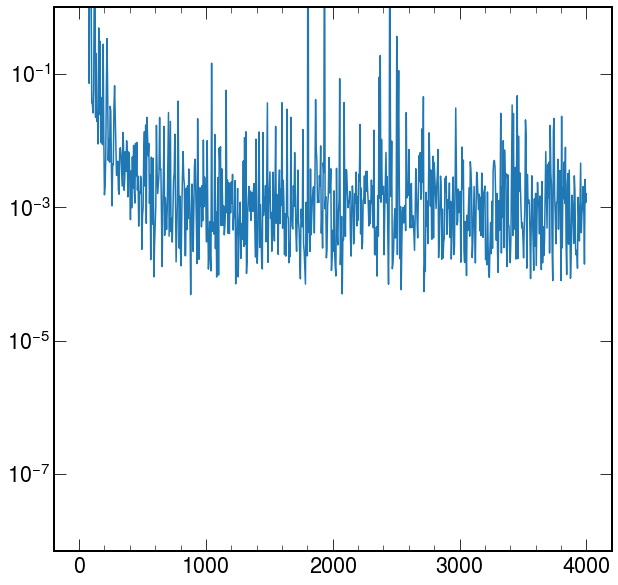

In [12]:
plt.plot(np.arange(0, 4001, 5), losses['kpd'][:, 0] + losses['kpd'][:, 1])
plt.yscale('log')
plt.ylim([0, 1])

/var/folders/fh/cwyrvktn5bz76x4cpy_lbgnh0000gn/T/ipykernel_33867/1878636150.py:3: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, 1])


(0.00010700613193850282, 1)

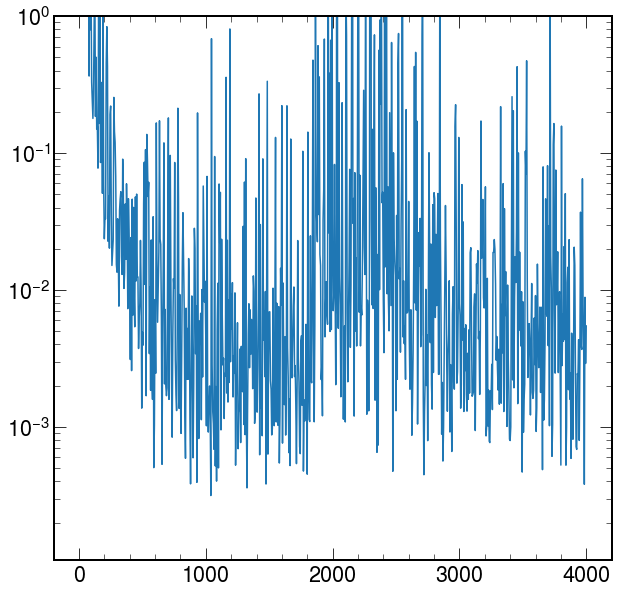

In [13]:
plt.plot(np.arange(0, 4001, 5), losses['fpd'][:, 0])
plt.yscale('log')
plt.ylim([0, 1])

In [64]:
losses['fpd'][np.argmin(losses['kpd'][:, 0])]

array([8.41654914e-03, 7.72168286e-05])

In [65]:
np.min(losses['fpd'][:, 0])

0.0003154177283105638

In [59]:
gen_efps = np.load(f"{data_dir}/{model}/1025_gen_efps.npy")
real_efps = np.load(f"{data_dir}/g.npy")

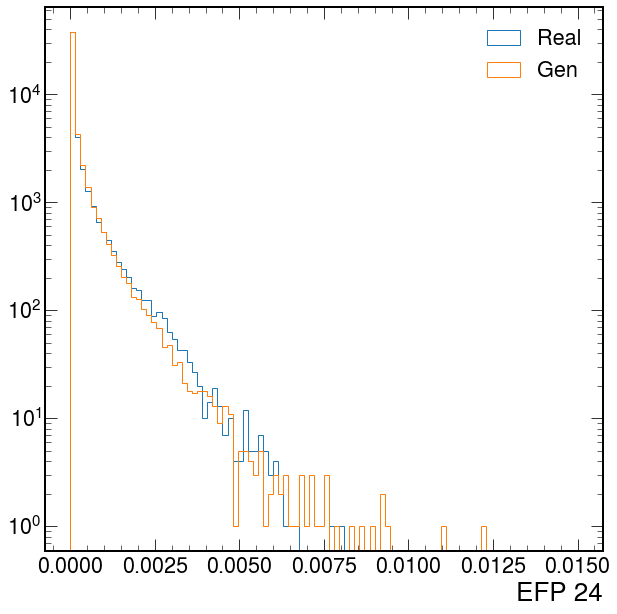

In [62]:
_ = plt.hist(real_efps[:, 24], np.linspace(0, 0.015, 101), histtype='step', label="Real")
_ = plt.hist(gen_efps[:, 24], np.linspace(0, 0.015, 101), histtype='step', label="Gen")
plt.yscale('log')
plt.xlabel("EFP 24")
# plt.xscale('log')
# plt.ylabel(r"$\overline{\mathrm{FGD}}_{\infty}^{+\sigma}$")
_ = plt.legend()

100%|██████████| 90/90 [09:09<00:00,  6.11s/it]


ValueError: 'x' and 'y' must have the same size

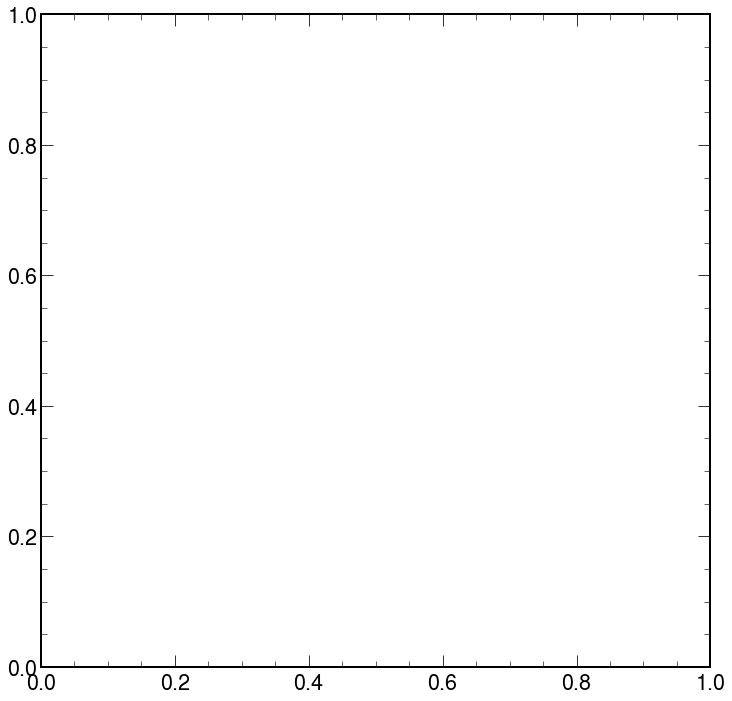

In [26]:
numb = 10
bs = 5000

# means_ses = []
means_ses = list(means_ses)
for i in tqdm(range(10, 100)):
    res = gen_metrics.multi_batch_evaluation_mmd(real_efps, efps, numb, bs, seed=i)
    means_ses.append([res[0], res[1]])

means_ses = np.array(means_ses)
plt.figure(figsize=(12, 12))
plt.errorbar(range(10), means_ses[:, 0], means_ses[:, 1], fmt="o")
plt.ylabel(r"FGD$_\infty$")
plt.ylim([-0.0001, 0.0001])
plt.xlabel("Seed")
plt.savefig(f"{plot_dir}/fgdinf_check_b{numb}_bs{bs}_vb_median_real.pdf")

In [37]:
gen_metrics.mmd_poly_quadratic_unbiased(real_efps / maxes, gen_efps / maxes, normalise=False, degree=4)

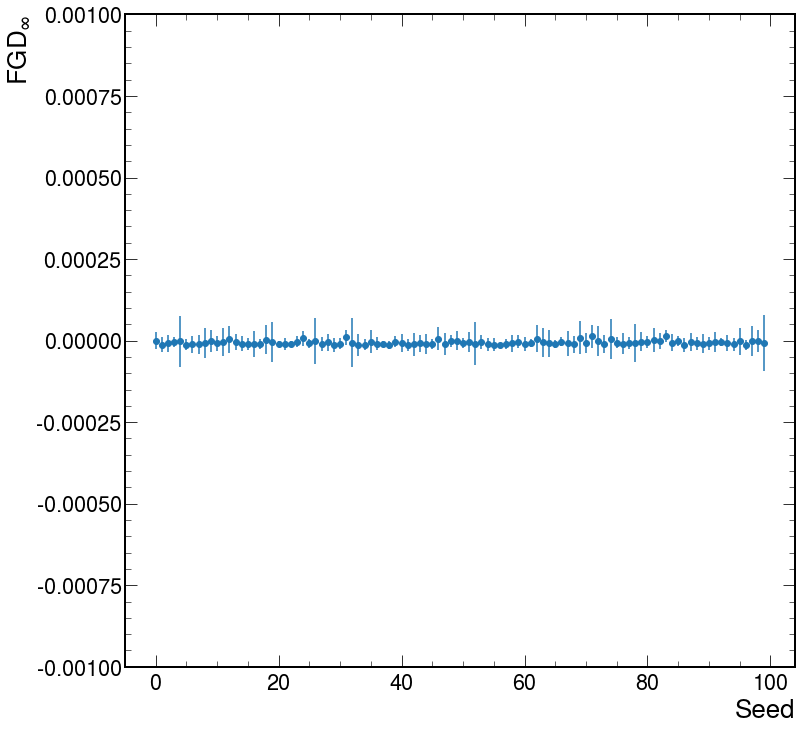

In [27]:
plt.figure(figsize=(12, 12))
plt.errorbar(range(100), means_ses[:, 0], means_ses[:, 1], fmt="o")
plt.ylabel(r"FGD$_\infty$")
plt.ylim([-0.001, 0.001])
plt.xlabel("Seed")
plt.savefig(f"{plot_dir}/fgdinf_check_b{numb}_bs{bs}_vb_median.pdf")

In [34]:
np.save(f"{plot_dir}/means_ses_b{numb}_bs{bs}_means_ses.npy", means_ses)

In [55]:
gen_metrics.multi_batch_evaluation_mmd(real_efps, gen_efps, 10, 5000, seed=42)

[0.05979190614663166, 0.0021019318993884886]

In [53]:
maxes = np.max(np.abs(real_efps), axis=0)
# maxes

In [54]:
np.random.seed(2 + 2 * 1000)
rand1 = np.random.choice(len(real_efps), size=bs)
rand2 = np.random.choice(len(gen_efps), size=bs)

rand_sample1 = real_efps[rand1] / maxes
rand_sample2 = gen_efps[rand2] / maxes

gen_metrics.mmd_poly_quadratic_unbiased(rand_sample1, rand_sample2, normalise=False, degree=4)

0.059471909231144426

In [16]:
real_efps.shape

(50000, 36)

In [17]:
truth_jets_pf, _ = JetNet.getData(
    "t",
    data_dir="/Users/raghav/Documents/CERN/gen-models/MPGAN/datasets/",
    split_fraction=[0.7, 0.3, 0],
    particle_features=["etarel", "phirel", "ptrel"],
    jet_features=["pt", "eta", "mass", "num_particles"],
)


In [18]:
efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])
# np.save("efps", efps)

In [19]:
gen_metrics.multi_batch_evaluation_mmd(real_efps, efps[:50000], 10, 5000, seed=42)

[-9.620001157006897e-06, 3.706804060898028e-05]

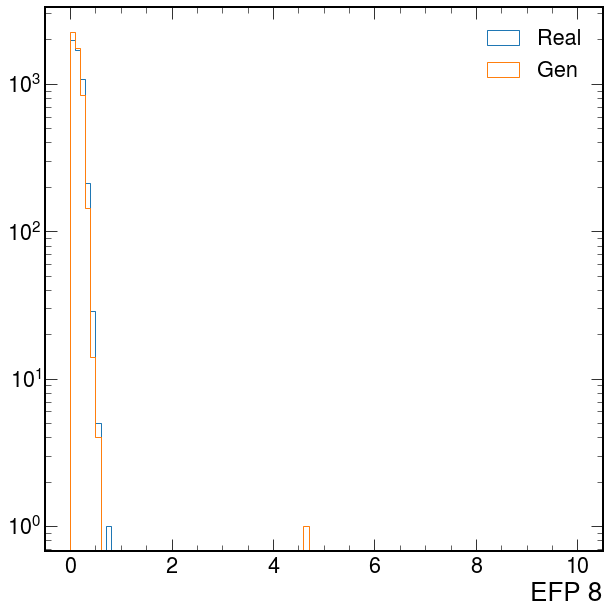

In [29]:
efp_num = 8
_ = plt.hist(rand_sample1[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Real")
_ = plt.hist(rand_sample2[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Gen")
plt.yscale('log')
plt.xlabel(f"EFP {efp_num}")
# plt.xscale('log')
# plt.ylabel(r"$\overline{\mathrm{FGD}}_{\infty}^{+\sigma}$")
_ = plt.legend()

-0.016275105633050124


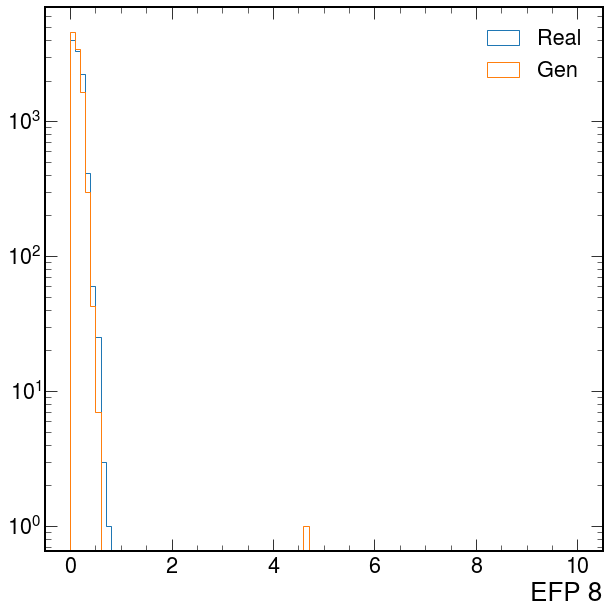

In [33]:
np.random.seed(2 + 0 * 1000)
bs = 10_000
rand1 = np.random.choice(len(real_efps), size=bs)
rand2 = np.random.choice(len(gen_efps), size=bs)

rand_sample1 = real_efps[rand1] / maxes
rand_sample2 = gen_efps[rand2] / maxes

print(gen_metrics.mmd_poly_quadratic_unbiased(rand_sample1, rand_sample2, normalise=False, degree=4))

efp_num = 8
_ = plt.hist(rand_sample1[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Real")
_ = plt.hist(rand_sample2[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Gen")
plt.yscale('log')
plt.xlabel(f"EFP {efp_num}")
# plt.xscale('log')
# plt.ylabel(r"$\overline{\mathrm{FGD}}_{\infty}^{+\sigma}$")
_ = plt.legend()

0.3540274742610232


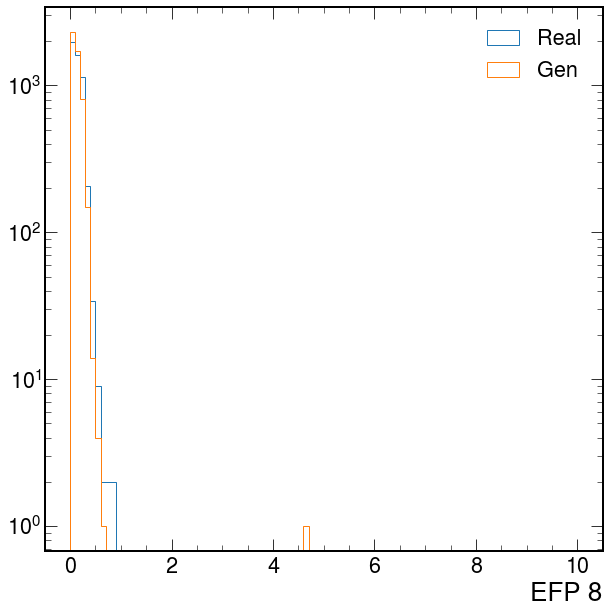

In [31]:
np.random.seed(2 + 1 * 1000)
rand1 = np.random.choice(len(real_efps), size=bs)
rand2 = np.random.choice(len(gen_efps), size=bs)

rand_sample1 = real_efps[rand1] / maxes
rand_sample2 = gen_efps[rand2] / maxes

print(gen_metrics.mmd_poly_quadratic_unbiased(rand_sample1, rand_sample2, normalise=False, degree=4))

efp_num = 8
_ = plt.hist(rand_sample1[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Real")
_ = plt.hist(rand_sample2[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Gen")
plt.yscale('log')
plt.xlabel(f"EFP {efp_num}")
# plt.xscale('log')
# plt.ylabel(r"$\overline{\mathrm{FGD}}_{\infty}^{+\sigma}$")
_ = plt.legend()

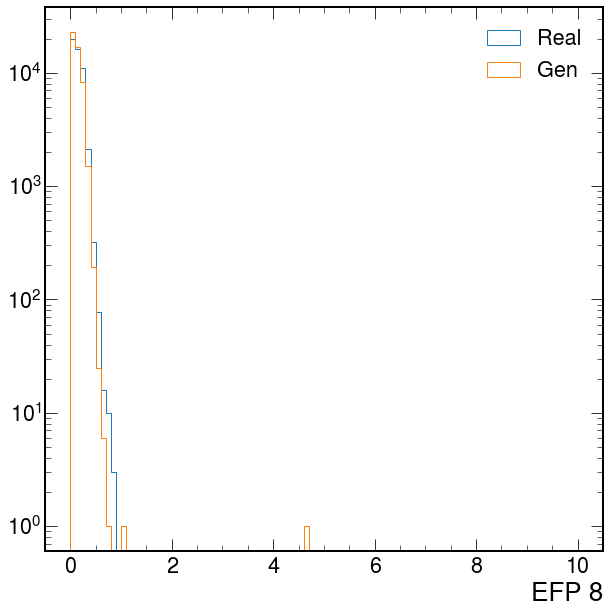

In [28]:
_ = plt.hist((real_efps / maxes)[:, efp_num] , np.linspace(0, 10, 101), histtype='step', label="Real")
_ = plt.hist((gen_efps / maxes)[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Gen")
plt.yscale('log')
plt.xlabel(f"EFP {efp_num}")
# plt.xscale('log')
# plt.ylabel(r"$\overline{\mathrm{FGD}}_{\infty}^{+\sigma}$")
_ = plt.legend()

In [60]:
gen_metrics.multi_batch_evaluation(real_efps, gen_efps, 10, 5000, gen_metrics.mmd_poly_quadratic_unbiased, degree=4)

(0.01116227711427209, 0.037398110893454496)

In [61]:
gen_metrics.multi_batch_evaluation(real_efps, gen_efps, 10, 5000, gen_metrics.mmd_poly_quadratic_unbiased, degree=4, seed=4)

(112059.57220834056, 336178.7174775638)

In [62]:
gen_metrics.multi_batch_evaluation(real_efps, gen_efps, 10, 5000, gen_metrics.mmd_poly_quadratic_unbiased, degree=4, seed=8)

(0.00010067931378512362, 0.002097296291338383)

In [63]:
gen_metrics.multi_batch_evaluation(real_efps, gen_efps, 10, 5000, gen_metrics.mmd_poly_quadratic_unbiased, degree=4, seed=4)

(112059.57220834056, 336178.7174775638)

In [86]:
gen_metrics.multi_batch_evaluation_mmd(real_efps, gen_efps, 10, 5000, seed=4)

[0.0009984806405981318, 0.00025388948962564556]

In [84]:
gen_metrics.multi_batch_evaluation_mmd(real_efps, gen_efps, 10, 5000, seed=10)

[-0.006835502689346784, 0.017899968788633994]

In [85]:
gen_metrics.multi_batch_evaluation_mmd(real_efps, gen_efps, 10, 5000, seed=12)

[0.040841007990459574, 0.1221963884258693]